In [1]:
# Load data

# NSL-KDD
# https://www.unb.ca/cic/datasets/nsl.html

import os
import pandas as pd
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from joblib import dump, load
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

columns=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class']

train_path = '/Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/nsl-kdd/NSL-KDD/train/KDDTrain+.txt'
test_path = '/Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/nsl-kdd/NSL-KDD/test/KDDTest+.txt'
df_train = pd.read_csv(train_path, header=None, names=columns, usecols=range(0,42))
df_test = pd.read_csv(test_path, header=None, names=columns, usecols=range(0,42))


In [2]:
df_train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [3]:
df_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# convert class into numerics

cols_to_numeric = df_train.select_dtypes(include=['object']).columns.drop(['protocol_type', 'service', 'flag', 'class'])

df_train[cols_to_numeric] = df_train[cols_to_numeric].apply(pd.to_numeric)
df_test[cols_to_numeric] = df_test[cols_to_numeric].apply(pd.to_numeric)

# Apply scaling to all relevant columns in train and then transform test as well

scaler = StandardScaler()
cols_to_scale = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 
                 'hot', 'num_failed_logins', 'num_compromised', 'su_attempted', 
                 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 
                 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

In [5]:
df_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.0,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,2.549477e-17,-4.512349e-19,7.614590e-19,0.000198,4.230328e-19,4.455945e-18,-2.244894e-17,2.989431e-18,0.395736,-6.549957e-18,0.001342,-3.666284e-19,3.581677e-18,-4.653360e-18,3.976508e-18,-5.302011e-18,0.0,0.000008,0.009423,-3.948306e-17,4.162642e-17,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,-1.756996e-17,-5.815290e-17,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,1.000004e+00,1.000004e+00,1.000004e+00,0.014086,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.489010,1.000004e+00,0.036603,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.0,0.002817,0.096612,1.000004e+00,1.000004e+00,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,1.000004e+00,1.000004e+00,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,0.000000,-2.443651e-02,-1.238515e-02,-2.618002e-02,-1.860990e-02,-4.122120e-02,0.0,0.000000,0.000000,-7.345115e-01,-3.818776e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.836071e+00,-1.044721e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,0.000000,-2.443651e-02,-1.238515e-02,-2.618002e-02,-1.860990e-02,-4.122120e-02,0.0,0.000000,0.000000,-7.170455e-01,-3.543429e-01,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,-1.009507e+00,-9.543885e-01,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.102492e-01,-7.754745e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,0.000000,-2.443651e-02,-1.238515e-02,-2.618002e-02,-1.860990e-02,-4.122120e-02,0.0,0.000000,0.000000,-6.122495e-01,-2.717387e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.343426e-01,-4.756270e-01,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-1.102492e-01,-7.715224e-03,-4.790326e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,1.000000,-1.166364e-02,0.000000,-2.443651e-02,-1.238515e-02,-2.618002e-02,-1.860990e-02,-4.122120e-02,0.0,0.000000,0.000000,5.143079e-01,-1.340650e-01,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,7.343426e-01,1.258754e+00,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,1.636428e+01,2.350675e+02,3.257486e+02,1.000000,1.174348e+01,2.088191e+02,3.571955e+01,1.104972e+02,1.000000,3.123689e+02,1.000000,4.426823e+01,3.060592e+02,8.882907e+01,9.014849e+01,9.053014e+01,0.0,1.000000,1.000000,3.728053e+00,6.653245e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.343426e-01,1.258754e+00,1.000000,1.000000,1.000000,1.000000,1.00

In [6]:
# Drop columns with 0 in all cells

df_train.drop(['num_outbound_cmds'],axis=1, inplace=True)
df_test.drop(['num_outbound_cmds'],axis=1, inplace=True)

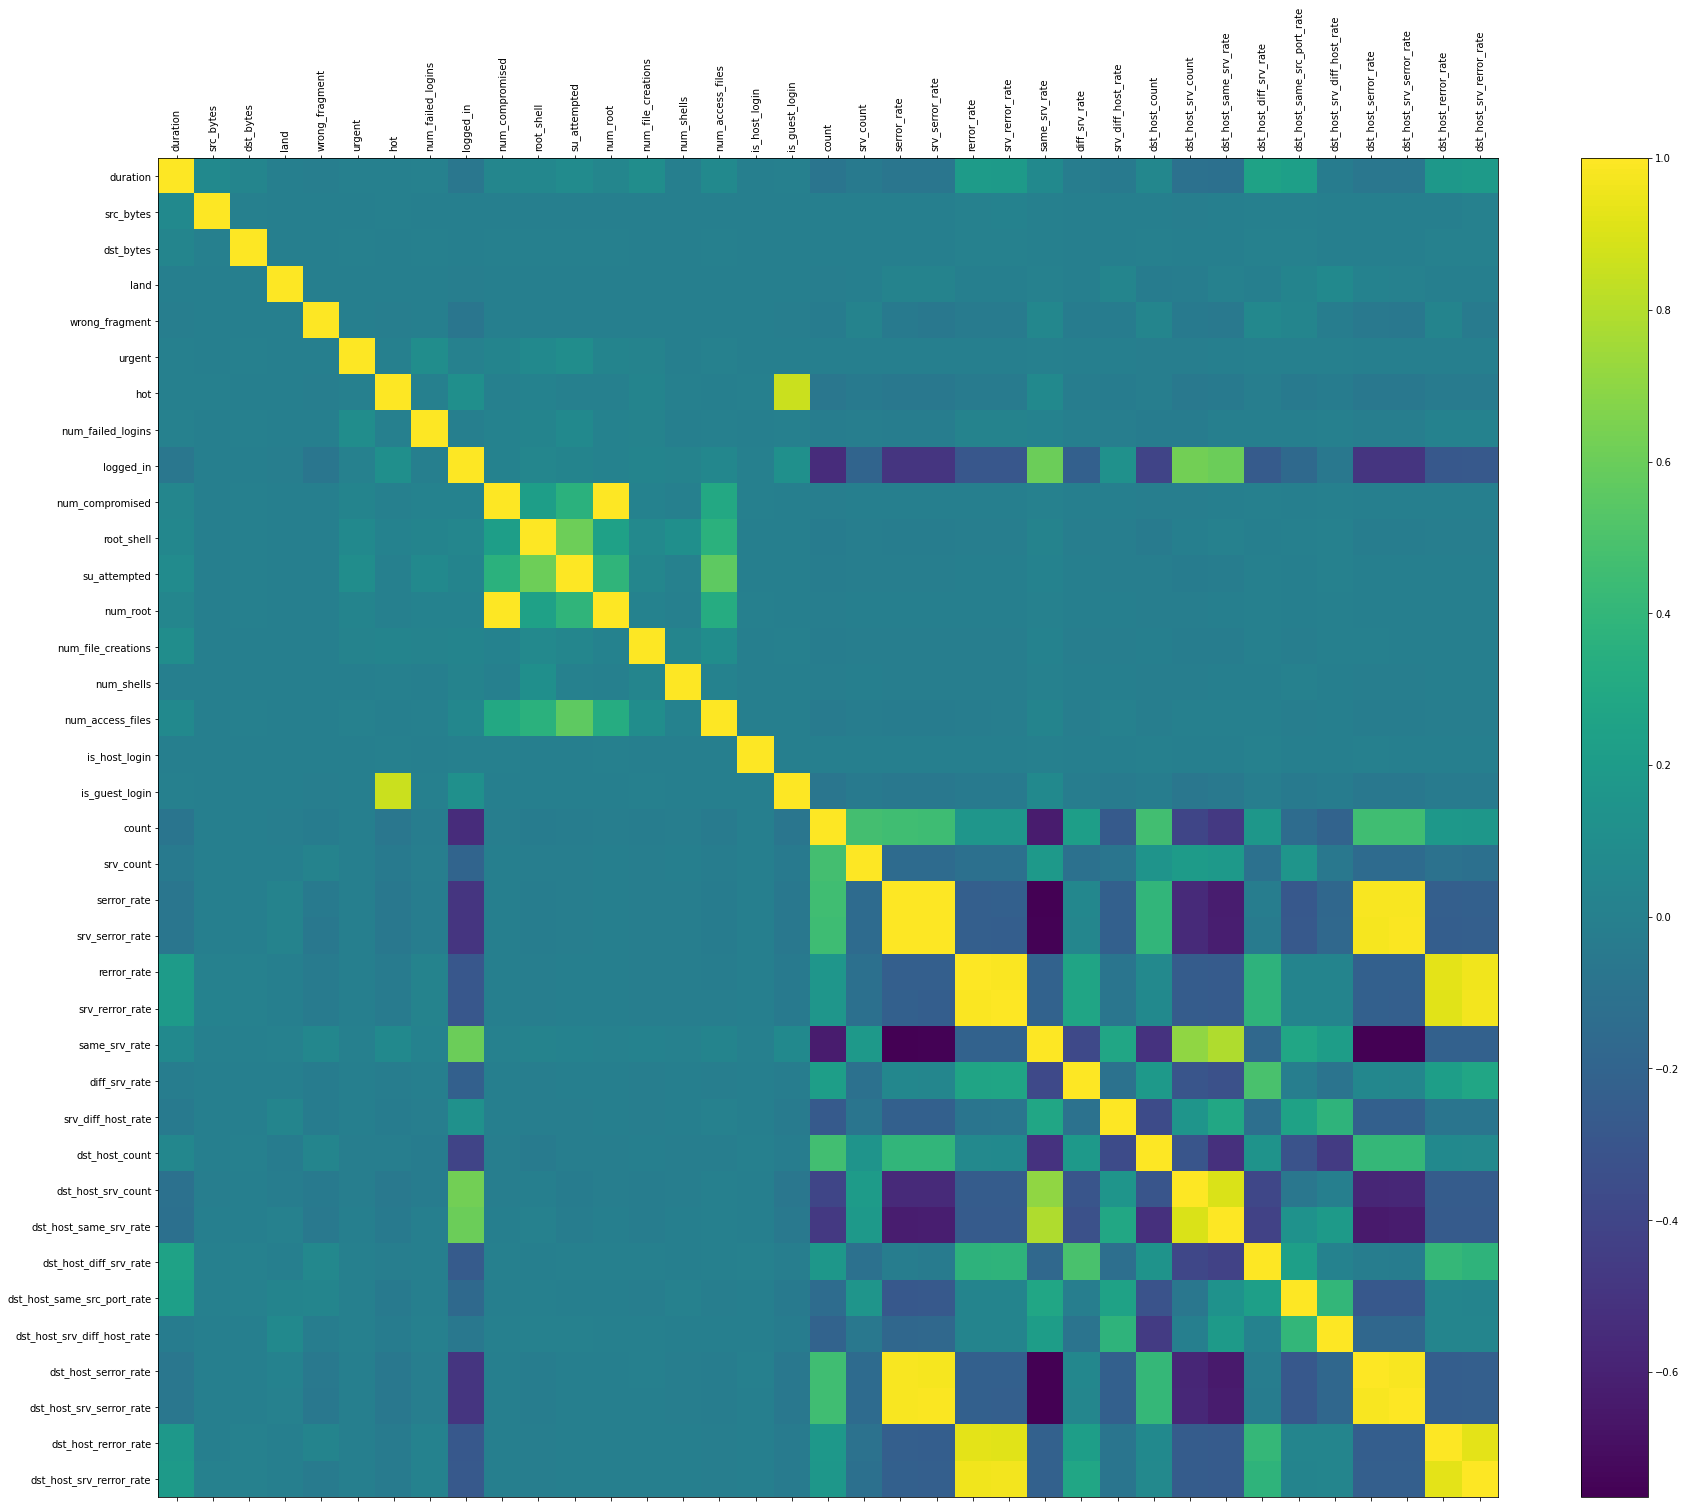

In [7]:
# Correlation matrix for all non-categorical features

df_corr = df_train.drop(['protocol_type', 'service', 'flag', 'class'],axis=1)

f = plt.figure(figsize=(30, 24))
plt.matshow(df_corr.corr(), fignum=f.number)
plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=10, rotation=90)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)


In [8]:
df_train['service'].value_counts()

http           40338
private        21853
domain_u        9043
smtp            7313
ftp_data        6860
eco_i           4586
other           4359
ecr_i           3077
telnet          2353
finger          1767
ftp             1754
auth             955
Z39_50           862
uucp             780
courier          734
bgp              710
whois            693
uucp_path        689
iso_tsap         687
time             654
imap4            647
nnsp             630
vmnet            617
urp_i            602
domain           569
ctf              563
csnet_ns         545
supdup           544
discard          538
http_443         530
daytime          521
gopher           518
efs              485
systat           477
link             475
exec             474
hostnames        460
name             451
mtp              439
echo             434
klogin           433
login            429
ldap             410
netbios_dgm      405
sunrpc           381
netbios_ssn      362
netstat          360
netbios_ns   

In [9]:
# Do one hot encoding for categorical columns and for service, limit to only top common services

df_train = pd.concat([df_train,
                      pd.get_dummies(df_train['protocol_type'], prefix='protocol_type'),
                      pd.get_dummies(df_train['flag'], prefix='flag')
                     ],axis=1)
df_train.drop(['protocol_type', 'flag'],axis=1, inplace=True)

df_test = pd.concat([df_test,
                      pd.get_dummies(df_test['protocol_type'], prefix='protocol_type'),
                      pd.get_dummies(df_test['flag'], prefix='flag')
                     ],axis=1)
df_test.drop(['protocol_type', 'flag'],axis=1, inplace=True)

In [10]:
def service_checker(row, service):
    if row['service'] == service:
        return 1
    else:
        return 0

In [11]:
# For service type

services = ['http', 'private', 'domain_u', 'smtp', 'ftp_data', 'eco_i', 'other', 'ecr_i', 'telnet', 'finger', 'ftp']

print('df_train:')

for service in services:
    col_name = 'service_' + service
    df_train[col_name] = df_train.apply(lambda row: service_checker(row, service), axis=1)
    df_test[col_name] = df_test.apply(lambda row: service_checker(row, service), axis=1)
    print('added', col_name)

df_train.drop(['service'],axis=1, inplace=True)
df_test.drop(['service'],axis=1, inplace=True)

df_train:
added service_http
added service_private
added service_domain_u
added service_smtp
added service_ftp_data
added service_eco_i
added service_other
added service_ecr_i
added service_telnet
added service_finger
added service_ftp


In [12]:
print(len(df_train.columns.values))
print(len(df_test.columns.values))

list(set(df_train.columns.values) - set(df_test.columns.values))


63
63


[]

In [13]:
# Determine columns in extended matrix with correlation >.95

corr_matrix = df_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_95 = [column for column in upper.columns if any(upper[column] > 0.95)]

to_drop_95

['num_root',
 'srv_serror_rate',
 'srv_rerror_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_srv_rerror_rate',
 'flag_S0']

In [14]:
df_train['class'].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: class, dtype: int64

In [15]:
# Function to group attacks into a larger subset

def attack_type_to_int(row):
    if row['class'] == 'normal':
        return 0
    elif row['class'] == 'neptune':
        return 1
    elif row['class'] == 'satan': 
        return 2
    elif row['class'] == 'ipsweep':
        return 3
    elif row['class'] == 'portsweep':
        return 4
    elif row['class'] == 'smurf': 
        return 5
    elif row['class'] == 'nmap':
        return 6
    elif row['class'] == 'back': 
        return 7
    elif row['class'] == 'teardrop':
        return 8
    elif row['class'] == 'warezclient':
        return 9
    elif row['class'] == 'pod':
        return 10
    else:
        return 11

In [16]:
df_train['attack_type'] = df_train.apply(lambda row: attack_type_to_int(row), axis=1)
df_train = df_train.drop('class', axis=1)

df_test['attack_type'] = df_test.apply(lambda row: attack_type_to_int(row), axis=1)
df_test = df_test.drop('class', axis=1)

df_train['attack_type'].value_counts()

0     67343
1     41214
2      3633
3      3599
4      2931
5      2646
6      1493
7       956
8       892
9       890
10      201
11      175
Name: attack_type, dtype: int64

In [17]:
# Maybe downsample for visualization?

df_visualization = df_train.copy(deep=True)

Explained variation per principal component: [0.14638477 0.12262273 0.07598916]


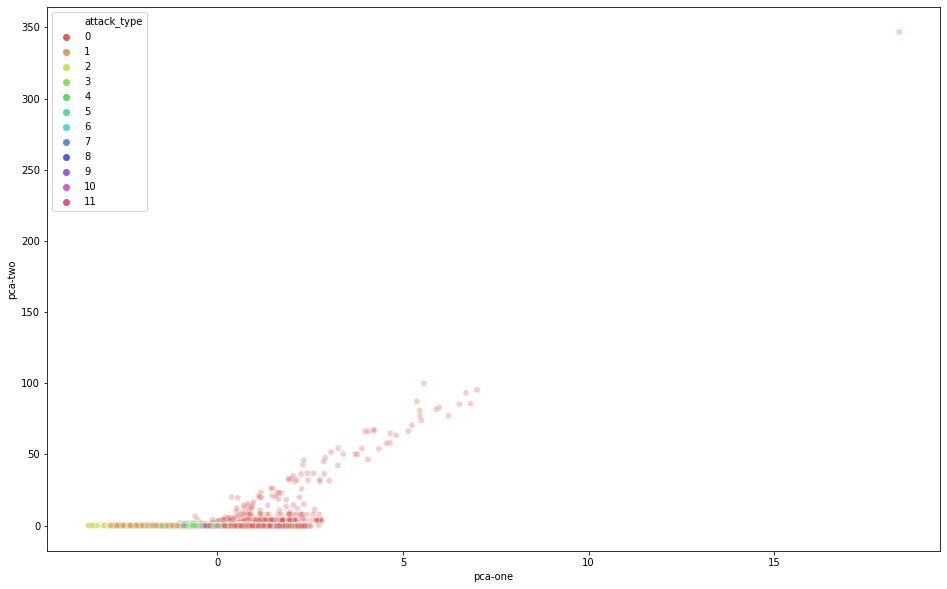

In [18]:
# PCA to see how principal component accounts for variance

df_visualization_features = df_visualization.drop('attack_type', axis=1)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_visualization_features.values)
df_visualization['pca-one'] = pca_result[:,0]
df_visualization['pca-two'] = pca_result[:,1] 
df_visualization['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# Plot 2D PCA

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="attack_type",
    palette=sns.color_palette("hls", 12),
    data=df_visualization,
    legend="full",
    alpha=0.3
)

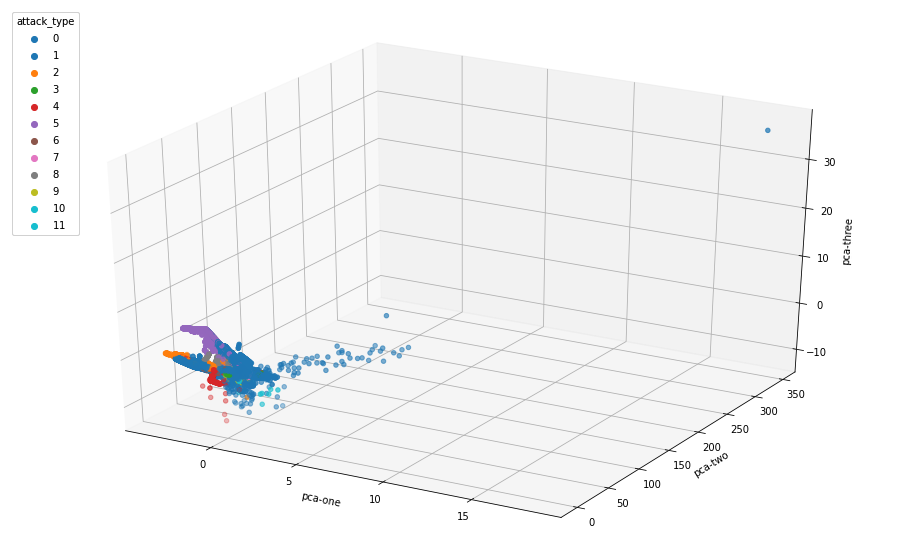

In [19]:
# Plot 3D PCA

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
graph = ax.scatter(
    xs=df_visualization["pca-one"], 
    ys=df_visualization["pca-two"], 
    zs=df_visualization["pca-three"], 
    c=df_visualization["attack_type"], 
    cmap='tab10',
)
legend1 = ax.legend(*graph.legend_elements(),
                    loc="upper left", title="attack_type")
ax.add_artist(legend1)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()



In [20]:
# Drop pca axes after use

df_visualization = df_visualization.drop(columns=['pca-one', 'pca-two', 'pca-three'], axis=1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 125973 samples in 20.734s...
[t-SNE] Computed neighbors for 125973 samples in 268.380s...
[t-SNE] Computed conditional probabilities for sample 1000 / 125973
[t-SNE] Computed conditional probabilities for sample 2000 / 125973
[t-SNE] Computed conditional probabilities for sample 3000 / 125973
[t-SNE] Computed conditional probabilities for sample 4000 / 125973
[t-SNE] Computed conditional probabilities for sample 5000 / 125973
[t-SNE] Computed conditional probabilities for sample 6000 / 125973
[t-SNE] Computed conditional probabilities for sample 7000 / 125973
[t-SNE] Computed conditional probabilities for sample 8000 / 125973
[t-SNE] Computed conditional probabilities for sample 9000 / 125973
[t-SNE] Computed conditional probabilities for sample 10000 / 125973
[t-SNE] Computed conditional probabilities for sample 11000 / 125973
[t-SNE] Computed conditional probabilities for sample 12000 / 125973
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 118000 / 125973
[t-SNE] Computed conditional probabilities for sample 119000 / 125973
[t-SNE] Computed conditional probabilities for sample 120000 / 125973
[t-SNE] Computed conditional probabilities for sample 121000 / 125973
[t-SNE] Computed conditional probabilities for sample 122000 / 125973
[t-SNE] Computed conditional probabilities for sample 123000 / 125973
[t-SNE] Computed conditional probabilities for sample 124000 / 125973
[t-SNE] Computed conditional probabilities for sample 125000 / 125973
[t-SNE] Computed conditional probabilities for sample 125973 / 125973
[t-SNE] Mean sigma: 0.000219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.806114
[t-SNE] KL divergence after 300 iterations: 5.031436


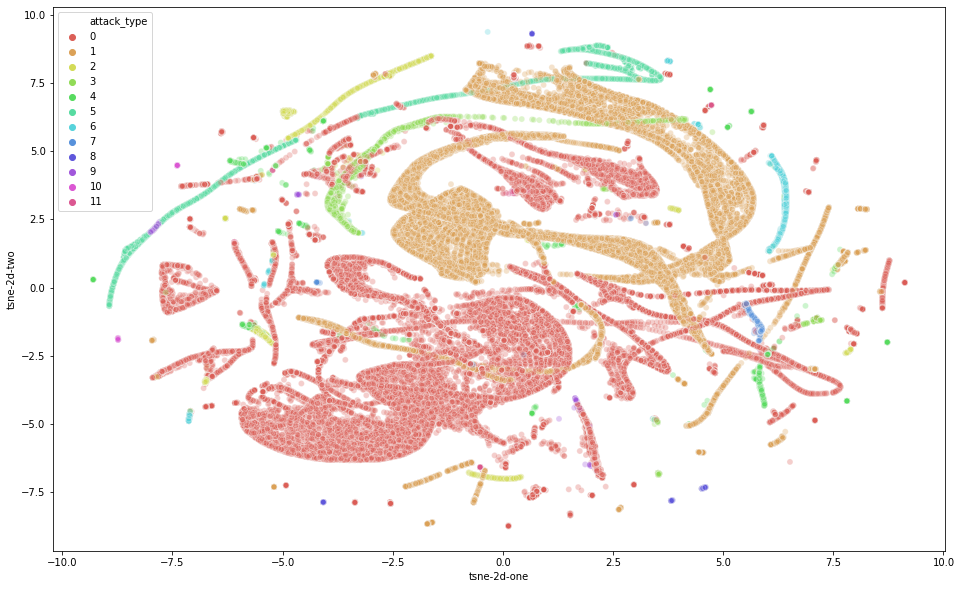

In [21]:
# Run TSNE on data

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_visualization_features)

df_visualization['tsne-2d-one'] = tsne_results[:,0]
df_visualization['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="attack_type",
    palette=sns.color_palette("hls", 12),
    data=df_visualization,
    legend="full",
    alpha=0.3
)

In [22]:
df_vis = df_train.copy(deep=True)

df_0 = df_vis[df_vis.attack_type==0]
df_1 = df_vis[df_vis.attack_type==1]
df_2 = df_vis[df_vis.attack_type==2]
df_3 = df_vis[df_vis.attack_type==3]
df_4 = df_vis[df_vis.attack_type==4]
df_5 = df_vis[df_vis.attack_type==5]
df_minority = df_vis[df_vis.attack_type>5]
 
df_0 = resample(df_0, replace=False, n_samples=20000, random_state=17) 
df_1 = resample(df_1, replace=False, n_samples=1000, random_state=17) 
df_2 = resample(df_2, replace=False, n_samples=3000, random_state=17) 
df_3 = resample(df_3, replace=False, n_samples=3000, random_state=17) 
df_4 = resample(df_4, replace=False, n_samples=2000, random_state=17) 
df_5 = resample(df_5, replace=False, n_samples=2000, random_state=17) 
 
df_visualization = pd.concat([df_0, 
                            df_1, 
                            df_2, 
                            df_3, 
                            df_4,
                            df_5,
                            df_minority])
 
df_visualization['attack_type'].value_counts()

0     20000
3      3000
2      3000
5      2000
4      2000
6      1493
1      1000
7       956
8       892
9       890
10      201
11      175
Name: attack_type, dtype: int64

In [23]:
# Run TSNE on data

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_visualization_features)

df_visualization['tsne-2d-one'] = tsne_results[:,0]
df_visualization['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="attack_type",
    palette=sns.color_palette("hls", 12),
    data=df_visualization,
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 125973 samples in 19.269s...
[t-SNE] Computed neighbors for 125973 samples in 308.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 125973
[t-SNE] Computed conditional probabilities for sample 2000 / 125973
[t-SNE] Computed conditional probabilities for sample 3000 / 125973
[t-SNE] Computed conditional probabilities for sample 4000 / 125973
[t-SNE] Computed conditional probabilities for sample 5000 / 125973
[t-SNE] Computed conditional probabilities for sample 6000 / 125973
[t-SNE] Computed conditional probabilities for sample 7000 / 125973
[t-SNE] Computed conditional probabilities for sample 8000 / 125973
[t-SNE] Computed conditional probabilities for sample 9000 / 125973
[t-SNE] Computed conditional probabilities for sample 10000 / 125973
[t-SNE] Computed conditional probabilities for sample 11000 / 125973
[t-SNE] Computed conditional probabilities for sample 12000 / 125973
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 123000 / 125973
[t-SNE] Computed conditional probabilities for sample 124000 / 125973
[t-SNE] Computed conditional probabilities for sample 125000 / 125973
[t-SNE] Computed conditional probabilities for sample 125973 / 125973
[t-SNE] Mean sigma: 0.000219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.285477
[t-SNE] KL divergence after 300 iterations: 5.064531


ValueError: Length of values does not match length of index

In [24]:
# Split dfs into features and labels
y_train = df_train['attack_type']
X_train = df_train.drop('attack_type', axis=1)
y_test = df_test['attack_type']
X_test = df_test.drop('attack_type', axis=1)

# Create train and test with correlated features removed
X_train_95 = X_train.drop(to_drop_95, axis=1)
X_test_95 = X_test.drop(to_drop_95, axis=1)

In [25]:
# Combine minority classes for better class balance

y_train = y_train.apply(lambda x: 1 if x > 0 else 0)
y_test = y_test.apply(lambda x: 1 if x > 0 else 0)

print(y_train.value_counts())
print(y_test.value_counts())

0    67343
1    58630
Name: attack_type, dtype: int64
1    12833
0     9711
Name: attack_type, dtype: int64


In [26]:
def fit_and_score_ensemble_classifier(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    print('Accuracy:', accuracy_score(y_test, y_pred), '\n')
    print(precision_recall_fscore_support(y_test, y_pred), '\n')
    print('F1_score:', f1_score(y_test, y_pred), '\n')
    print(classification_report(y_test, y_pred), '\n')
    print(confusion_matrix(y_test, y_pred), '\n')
    print(confusion_matrix(y_test, y_pred, normalize='true'), '\n')

    
def plot_feature_importances(model, labels, color):
    values = model.feature_importances_
    index = np.arange(len(labels))
    fig = plt.figure(figsize=(16, 10))
    plt.bar(index, values, color=color)
    plt.xlabel('Feature', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.xticks(index, labels, fontsize=10, rotation=90)
    plt.show()

def export_model(model, filename):
    # Dump to a retrievable file: model = load('filename.joblib') 
    dump(model, filename + '.joblib') 
    # save to Onnx file type
    initial_type = [('float_input', FloatTensorType([None, 70]))]
    onx = convert_sklearn(rf_model, initial_types=initial_type)
    with open(filename + '.onnx', 'wb') as f:
        f.write(onx.SerializeToString())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy: 0.7708924769339958 

(array([0.65839721, 0.96790334]), array([0.97291731, 0.61801605]), array([0.78533727, 0.75436344]), array([ 9711, 12833])) 

F1_score: 0.7543634374851381 

              precision    recall  f1-score   support

           0       0.66      0.97      0.79      9711
           1       0.97      0.62      0.75     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.80      0.77     22544
weighted avg       0.83      0.77      0.77     22544
 

[[9448  263]
 [4902 7931]] 

[[0.97291731 0.02708269]
 [0.38198395 0.61801605]] 



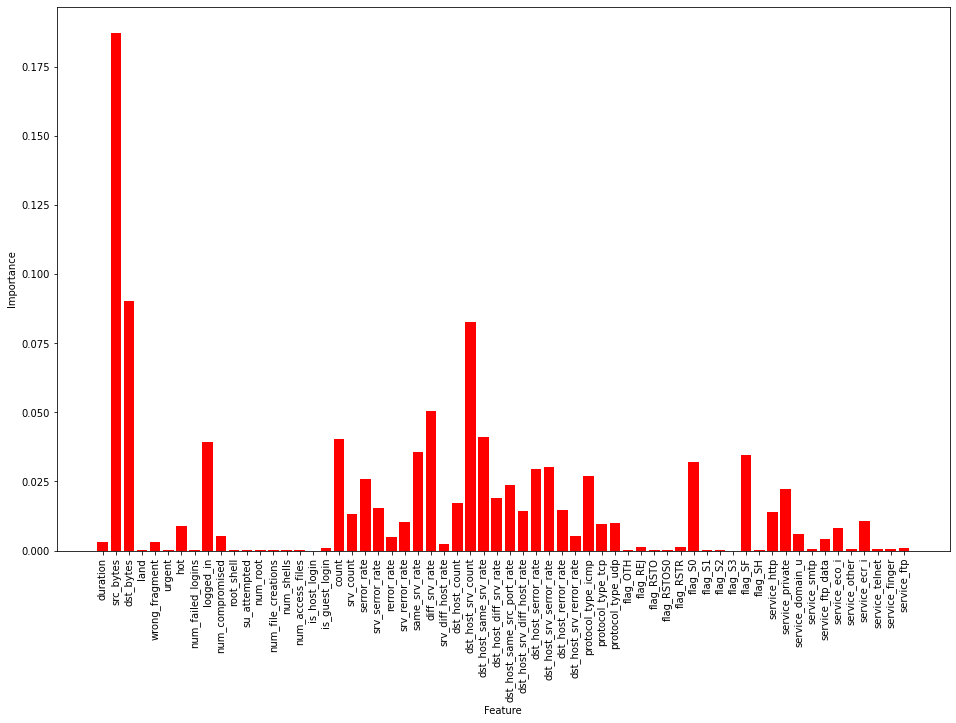

In [27]:
# Random Forest on all columns

rf_model = RandomForestClassifier(n_estimators=100, 
                            bootstrap = True,
                            max_features = 'sqrt',
                            verbose=True,
                            random_state=25)

fit_and_score_ensemble_classifier(rf_model, X_train, y_train, X_test, y_test)
plot_feature_importances(rf_model, X_train.columns, 'red')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy: 0.7775461320085166 

(array([0.66542201, 0.96814371]), array([0.97260838, 0.62993844]), array([0.79021125, 0.76325355]), array([ 9711, 12833])) 

F1_score: 0.7632535523769061 

              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.63      0.76     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.77     22544
 

[[9445  266]
 [4749 8084]] 

[[0.97260838 0.02739162]
 [0.37006156 0.62993844]] 



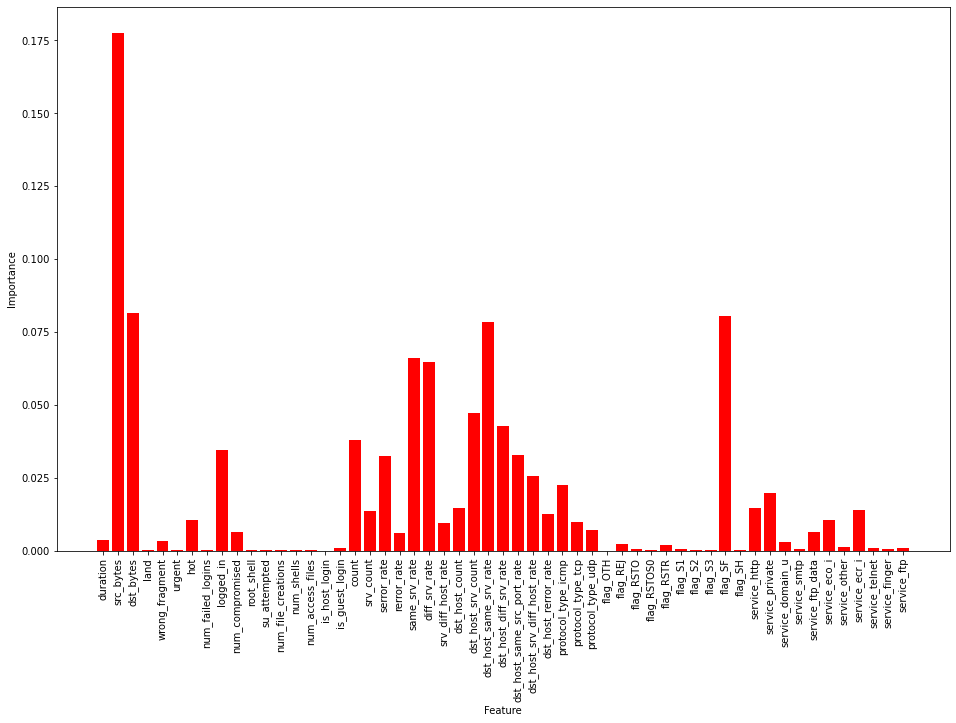

In [28]:
# Random Forest Classifier on reduced_95 

rf_model_95 = RandomForestClassifier(n_estimators=100, 
                            bootstrap = True,
                            max_features = 'sqrt',
                            verbose=True,
#                             class_weight={0:1,1:10},
                            random_state=25)

fit_and_score_ensemble_classifier(rf_model_95, X_train_95, y_train, X_test_95, y_test)
plot_feature_importances(rf_model_95, X_train_95.columns, 'red')

Accuracy: 0.7883250532292406 

(array([0.67711396, 0.9686083 ]), array([0.97219648, 0.64918569]), array([0.79825822, 0.77736307]), array([ 9711, 12833])) 

F1_score: 0.7773630680227676 

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544
 

[[9441  270]
 [4502 8331]] 

[[0.97219648 0.02780352]
 [0.35081431 0.64918569]] 



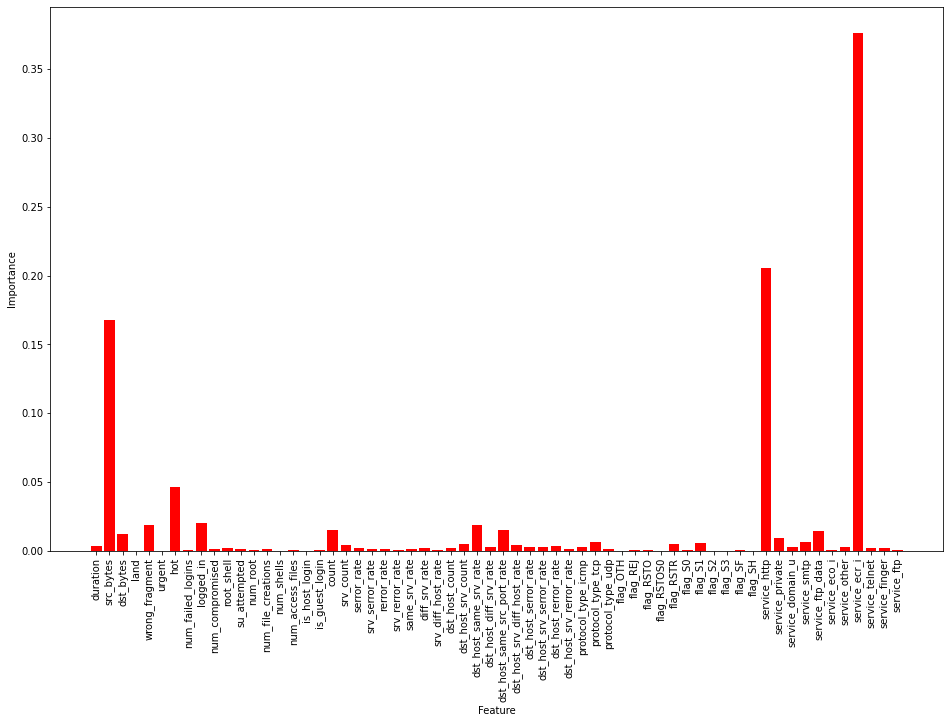

In [29]:
# XGB on all columns

xgb_model = XGBClassifier(verbosity=1, importance_type='gain', random_state=25)

fit_and_score_ensemble_classifier(xgb_model, X_train, y_train, X_test, y_test)
plot_feature_importances(xgb_model, X_train.columns, 'red')

Accuracy: 0.7938697657913414 

(array([0.68326578, 0.9689505 ]), array([0.9720935 , 0.65900413]), array([0.80248225, 0.78447196]), array([ 9711, 12833])) 

F1_score: 0.7844719632670099 

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.66      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.83      0.82      0.79     22544
weighted avg       0.85      0.79      0.79     22544
 

[[9440  271]
 [4376 8457]] 

[[0.9720935  0.0279065 ]
 [0.34099587 0.65900413]] 



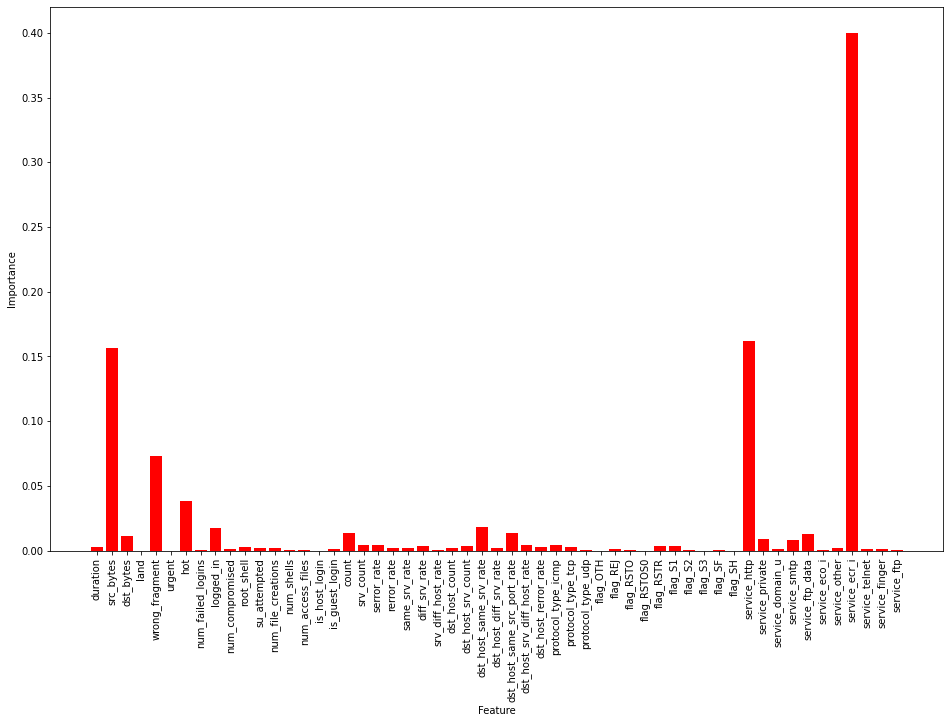

In [33]:
# XGB on 95 reduced

xgb_model_95 = XGBClassifier(verbosity=1, importance_type='gain', random_state=25)

fit_and_score_ensemble_classifier(xgb_model_95, X_train_95, y_train, X_test_95, y_test)
plot_feature_importances(xgb_model_95, X_train_95.columns, 'red')

Accuracy: 0.7798083747338538 

(array([0.6680354 , 0.96733579]), array([0.9716816 , 0.63461389]), array([0.79174358, 0.76642198]), array([ 9711, 12833])) 

F1_score: 0.7664219838132881 

              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.63      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.78     22544
 

[[9436  275]
 [4689 8144]] 

[[0.9716816  0.0283184 ]
 [0.36538611 0.63461389]] 



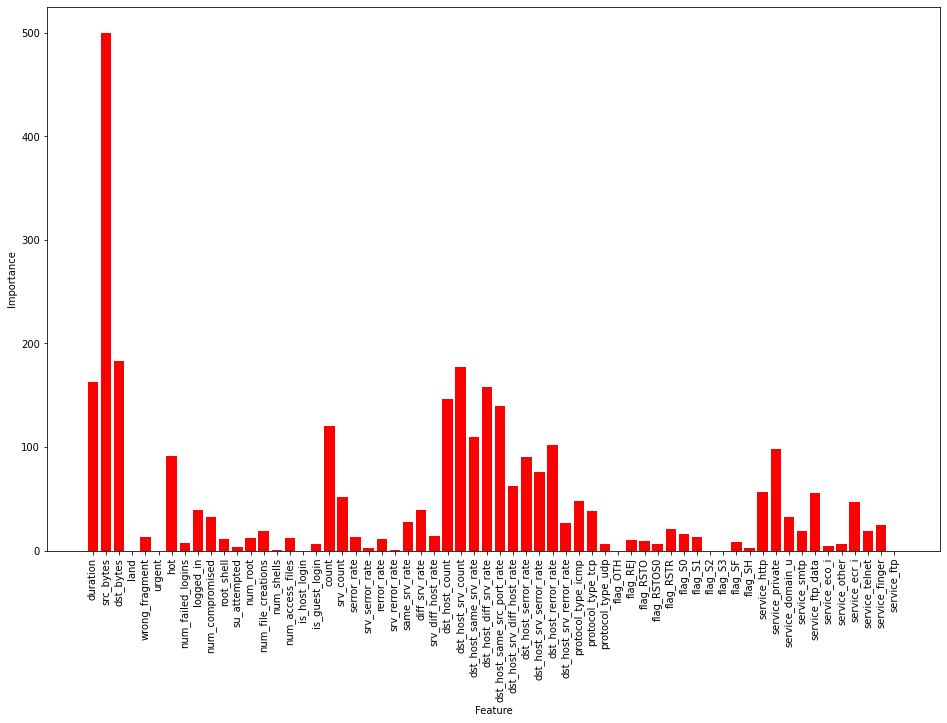

In [34]:
# LGBM on all columns

lgbm_model = LGBMClassifier(silent=False, random_state=25)

fit_and_score_ensemble_classifier(lgbm_model, X_train, y_train, X_test, y_test)
plot_feature_importances(lgbm_model, X_train.columns, 'red')

Accuracy: 0.7895227111426544 

(array([0.67853034, 0.96827235]), array([0.97178457, 0.65160134]), array([0.79910242, 0.77898365]), array([ 9711, 12833])) 

F1_score: 0.778983650845405 

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544
 

[[9437  274]
 [4471 8362]] 

[[0.97178457 0.02821543]
 [0.34839866 0.65160134]] 



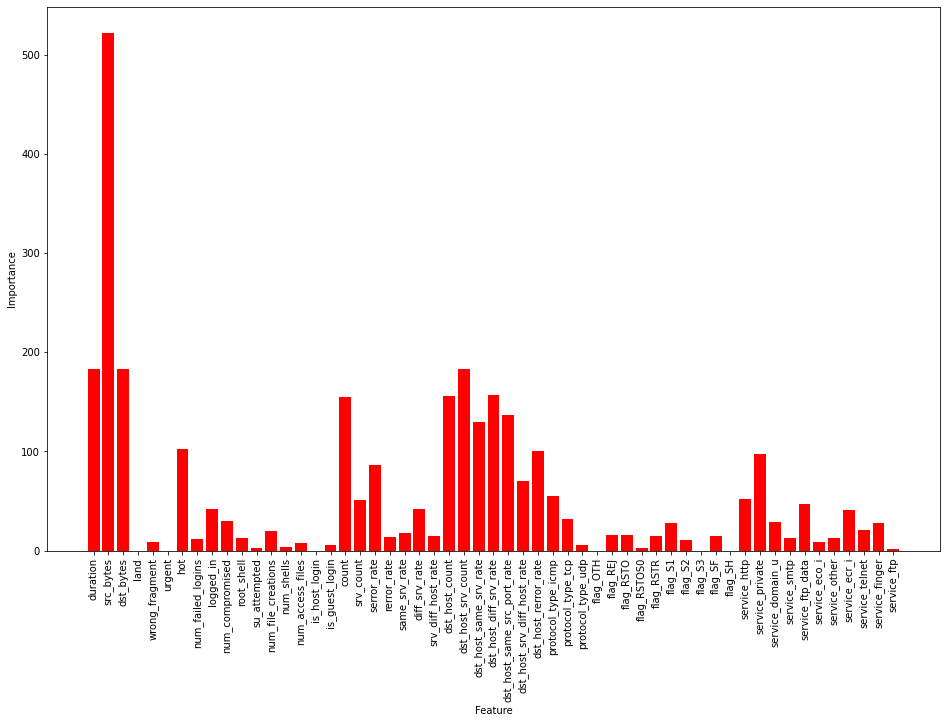

In [35]:
# LGBM on 95 reduced

lgbm_model_95 = LGBMClassifier(silent=False, random_state=1001)

fit_and_score_ensemble_classifier(lgbm_model_95, X_train_95, y_train, X_test_95, y_test)
plot_feature_importances(lgbm_model_95, X_train_95.columns, 'red')